In [12]:
import sys; sys.path.insert(0,'..')
from contxt import *
import plotnine as p9

In [34]:
df_all=pd.read_pickle('../data/data.absconc_richardson.pkl').reset_index()
df = df_all[df_all.absconc_words_num>=10]
# figdf

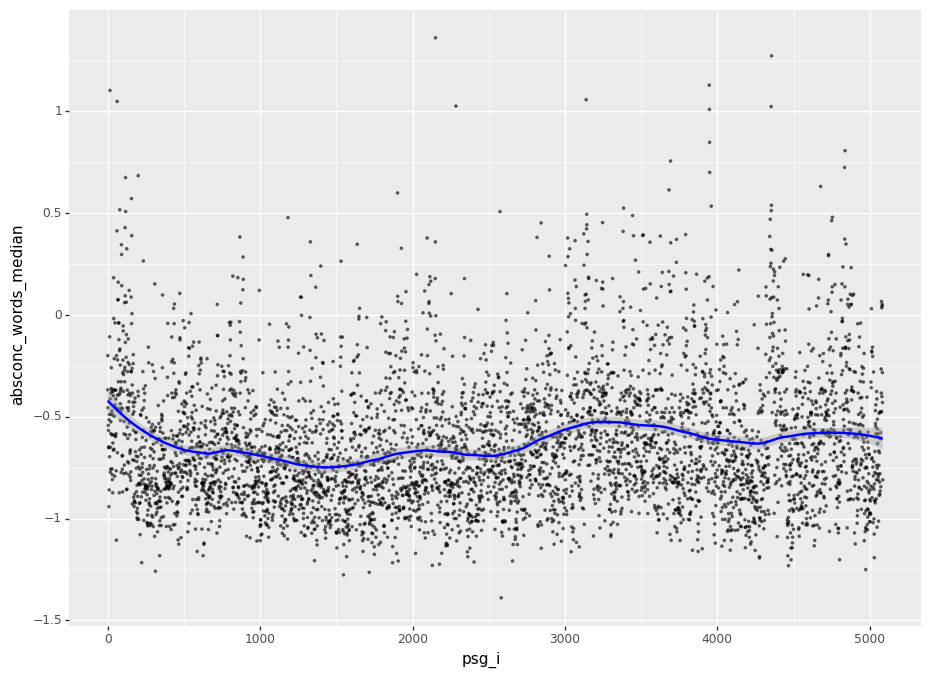

<ggplot: (360562598)>

In [35]:
p9.options.figure_size=11,8
figdf = df
figaes = p9.aes(x='psg_i',y='absconc_words_median')
fig = p9.ggplot(figdf,figaes)
fig+=p9.geom_point(size=.5, alpha=.5)
fig+=p9.geom_smooth(method='loess', color='blue', span=.3)
fig

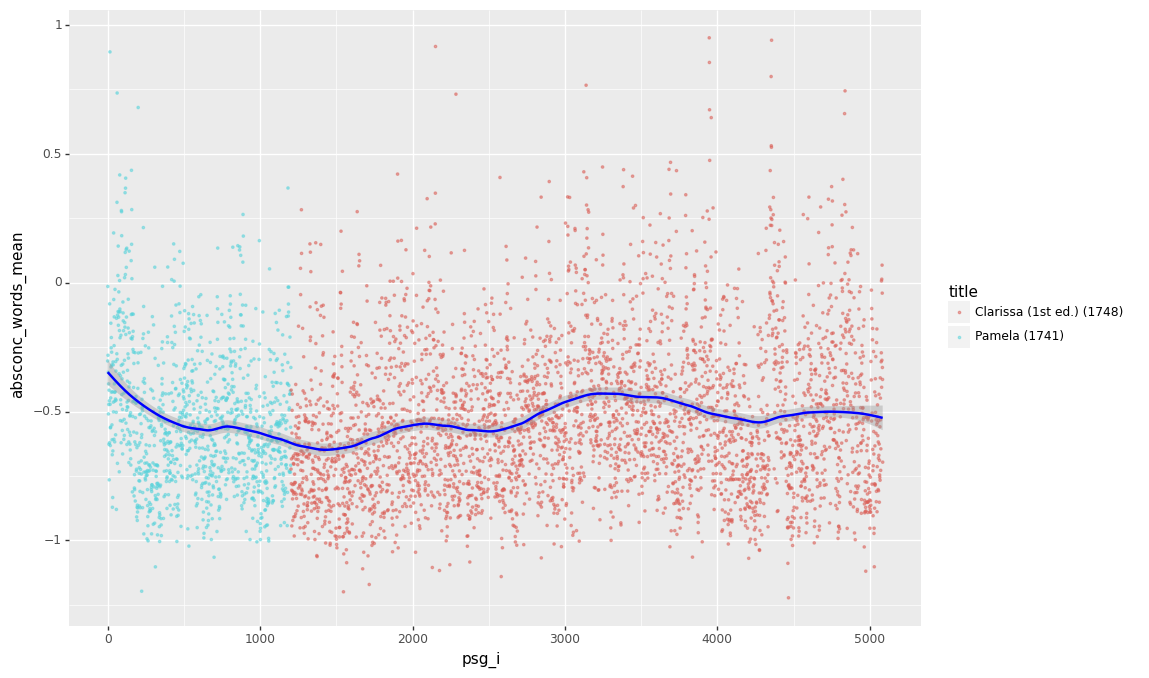

<ggplot: (751588910)>

In [39]:
figaes = p9.aes(x='psg_i',y='absconc_words_mean',color='title')
figdf = df
fig = p9.ggplot(figdf,figaes)
fig+=p9.geom_point(size=.5, alpha=.5)
fig+=p9.geom_smooth(method='loess', color='blue', span=.3)
fig

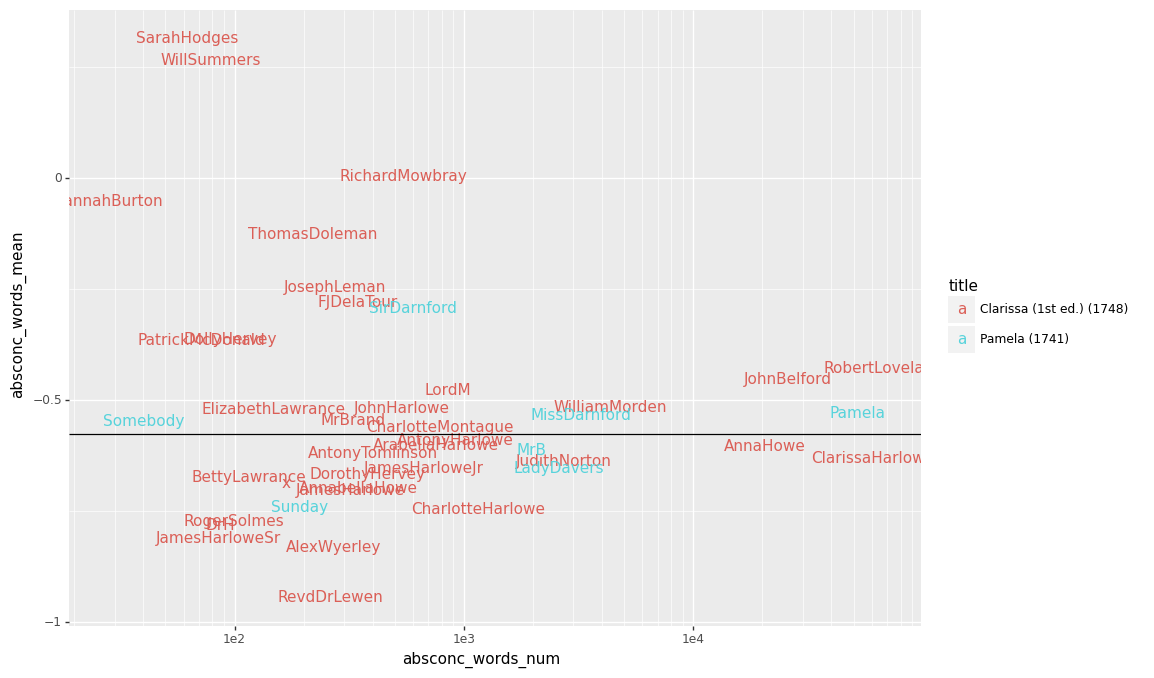

<ggplot: (353706445)>

In [66]:
figdf = df.groupby(['sender_id','title']).agg(
    {
        c:np.mean if not c.endswith('_num') else np.sum
        for c in df.select_dtypes('number')
    }
).reset_index()

figdf=figdf[figdf.sender_id!='?']
figdf=figdf[~figdf.sender_id.str.contains(' ')]
# figdf

fig=p9.ggplot(figdf, p9.aes(y='absconc_words_num', x='absconc_words_mean',label='sender_id', color='title'))
fig+=p9.geom_text()
fig+=p9.scale_y_log10()
fig+=p9.geom_vline(xintercept=figdf['absconc_words_mean'].median())
fig+=p9.coord_flip()
fig

In [184]:
def iter_graphs(df):
    import networkx as nx
    g = nx.DiGraph()
    for i,row in get_tqdm(df.iterrows(), total=len(df)):
        wordscores=row.absconc_words_str.split('; ')
        words = [w.split('(')[0].strip() for w in wordscores if '(' in w]
        scores = [get_absconc_wordscores().get(w) for w in words]

        for a in row.sender_id.split('; '):
            for b in row.recip_id.split('; '):
                
                # node
                for n in [a,b]:
                    if not g.has_node(n): g.add_node(n, words=[], scores=[], weight=0, absconc=None)
                
                # speaker
                g.nodes[a]['words']+=words
                g.nodes[a]['scores']+=scores
                g.nodes[a]['absconc']=float(np.mean(g.nodes[n]['scores']))
                g.nodes[a]['counts']=Counter(g.nodes[a]['words']).most_common()
                g.nodes[a]['weight']+=1
                    
                # edge
                if not g.has_edge(a,b): g.add_edge(a,b,words=[],scores=[], weight=0, absconc=None)
                g.edges[a,b]['words']+=words
                g.edges[a,b]['scores']+=scores
                g.edges[a,b]['absconc']=float(np.mean(g.edges[a,b]['scores']))
                g.edges[a,b]['counts']=Counter(g.edges[a,b]['words']).most_common()
                g.edges[a,b]['weight']+=1
        
        yield g
        
def get_graph(df):
    for g in iter_graphs(df): pass
    return clean_g(g)

def clean_g(g):
    og = nx.DiGraph()
    for n in g.nodes():
        og.add_node(n, **{k:(json.dumps(v) if type(v) not in {float,int,str} else v) for k,v in g.nodes[n].items() if k not in {'words','scores'}})
    for a,b,d in g.edges(data=True):
        og.add_edge(a,b, **{k:(json.dumps(v) if type(v) not in {float,int,str} else v) for k,v in d.items() if k not in {'words','scores'}})
    return og

In [185]:
# %%timeit
#get_absconc_wordscores().get('trouble')
pamela=df[df.title=='Pamela (1741)']
clarissa=df[df.title=='Clarissa (1st ed.) (1748)']

In [187]:
# nx.write_graphml(get_graph(pamela), 'data.pamela.graphml')
nx.write_graphml(get_graph(clarissa), 'data.clarissa.graphml')

100%|████████████████████████████████| 3740/3740 [00:18<00:00, 204.12it/s]
